In [145]:
import os
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid') ### seaborn gives a nice design

In [2]:
cd /home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/scripts

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/scripts


In [3]:
from _helpers import *
from make_summary import assign_carriers
from plot_summary import plot_costs

## Upload network

In [40]:
##Upload ALL scnearios

#defines folder where the solved networks are (.nc files)
directory = r'/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/'
network_paths = []
#iterates through all the solved networks
for entry in os.scandir(directory):
    if entry.path.endswith(".nc") and entry.is_file():
        #create a list with all the file paths:
        network_paths.append(entry.path)
    
#Sort list
network_paths.sort()

print("\n".join(network_paths[0:]))


/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.00000.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.00001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.0001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.001.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.01.nc
/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.1.nc
/home/max/OneDrive/PHD-Flexibility/08_

In [99]:
#create a dictionary that contains networks abbr. ns
ns = {}

for i in range(0, len(network_paths)): ##full list
#for i in range(0, 3): ##just testing
    ns["n%s" %(i+10)] = pypsa.Network(network_paths[i])
    
ns

##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.00000.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the f

{'n10': Network ,
 'n11': Network ,
 'n12': Network ,
 'n13': Network ,
 'n14': Network ,
 'n15': Network ,
 'n16': Network ,
 'n17': Network ,
 'n18': Network ,
 'n19': Network ,
 'n20': Network ,
 'n21': Network ,
 'n22': Network ,
 'n23': Network ,
 'n24': Network ,
 'n25': Network ,
 'n26': Network ,
 'n27': Network ,
 'n28': Network ,
 'n29': Network ,
 'n30': Network ,
 'n31': Network ,
 'n32': Network ,
 'n33': Network ,
 'n34': Network ,
 'n35': Network ,
 'n36': Network ,
 'n37': Network ,
 'n38': Network ,
 'n39': Network }

In [ ]:
#pd.DataFrame.from_dict(ns.keys())

In [97]:
(len(network_paths)+10)

40

## Data preparation

### Amount of unintended cycling

The following steps are described below to detect unintended storage cycling:
1. Reading efficiencies
2. Create charging and discharging timeseries
3. Calculate amount of aggregated unintended storage cycling [MWh]
4. Summary outputs

#### 1. Reading efficiencies

In [7]:
cd '/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling'

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling


In [8]:
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
costs.head()

,technology,year,parameter,value,unit,source
0,solar-rooftop,2030,discount rate,0.04,per unit,standard for decentral
1,onwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
2,offwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
3,solar,2030,lifetime,25.00,years,IEA2010
4,solar-rooftop,2030,lifetime,25.00,years,IEA2010


In [9]:
##READING EFFICIENCY
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
electrolysor_effi = costs.iloc[89]['value']
fuel_cell_effi = costs.iloc[93]['value']
battery_effi = costs.iloc[115]['value']

print(electrolysor_effi)
print(fuel_cell_effi)
print(battery_effi)

0.8
0.58
0.9


## 2. Functions. Create charging and Discharging Timeseries

Dataframe should look like:
USC(y-xis).sum for battery and H2 
MC(x-axis)

##Y-Axis MAYBE SMT LIKE BELOW:

Counting USC: print("USC/Discharge",(df['usc_h2'].mean()/df['p3_h2'].mean()))


##Generated indicators
Artificial FLH Discharger = (df['p3_h2']/df['p3_h2'].max()).mean()*8760) 
True FLH Discharger = ((df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760)             # not sure if corr. works
USC indicator as percentage over the year = (Artificial/True FLH)/8760 
USC indicator as percentage over the year = ((df['p0_b']-df['p0_b_corr'])/df['p0_b_corr'].max()).mean() 
USC indicator as timeseries = ((df['p0_h2']-df['p0_h2_corr'])/df['p0_h2_corr'].max())     # not sure if corr. works
USC curtailment =  usc_b[col][row] or  usc_h2[col][row] 


#Note that ['usc_h2'] includes charging and discharging artififical curtailment.
#example definition (p2_b[col][row] - p3_b[col][row]) + p2_b[col][row] / battery_effi

In [10]:
def create_p_df(n, name):
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

    p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()


    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
    df['p0_b'] = p0_b.sum(axis=1)
    df['p1_b'] = p1_b.sum(axis=1)
    df['p2_b'] = p2_b.sum(axis=1)
    df['p3_b'] = p3_b.sum(axis=1)
    df['type'] = name
    return(df)

#### 3. Calculate amount of aggregated unintended storage cycling 

In [11]:

def add_pcorr_and_usc_2_df(n, name):

    ## CHARGING AND DISCHARGING TIMESERIES
        # p0 & p1 are related to charging
        # p2 & p3 are related to discharging
        # p0 * effi = p1

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## REMOVES THE COLUMN INDEX (Code explanation)
        #.transpose().reset_index(drop = True, inplace = False).transpose()

    p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

    p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
    p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

    #Dataframes
    df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
    df['p1_h2'] = p1_h2.sum(axis=1)
    df['p2_h2'] = p2_h2.sum(axis=1)
    df['p3_h2'] = p3_h2.sum(axis=1)
    df['p0_b'] = p0_b.sum(axis=1)
    df['p1_b'] = p1_b.sum(axis=1)
    df['p2_b'] = p2_b.sum(axis=1)
    df['p3_b'] = p3_b.sum(axis=1)
    
    ## CHARGING AND DISCHARGING TIMESERIES
        # usc_h2 = timeseries of unintended storage cycling for hydrogen storage for all buses
        # usc_b = timeseries of unintended storage cycling for battery storage for all busses

    ## Abbreviations
        #h2 = Hydrogen storage
        #b = battery storage

    ## Number of required iterations
    i = p0_h2.shape[1] # number of columns
    j = p0_h2.shape[0] # number of rows

    ## Create empty dataframe

    usc_h2 = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in H2
    usc_b = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in Battery
    p0_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p1_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p2_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p3_h2_corr = pd.DataFrame(np.zeros((j, i)))
    p0_b_corr = pd.DataFrame(np.zeros((j, i)))
    p1_b_corr = pd.DataFrame(np.zeros((j, i)))
    p2_b_corr = pd.DataFrame(np.zeros((j, i)))
    p3_b_corr = pd.DataFrame(np.zeros((j, i)))

    #Charge and discharge should never happen at the same time, as it is equal to dissipating energy. 
    #Dissipating energy in an energy storage is too expensive since it reduces the lifetime of these relative expensive devices.
    #There are cheaper ways to dissipate energy such as curtailing VRE or using electric coils.

    #Having charge and discharge at the same time is a signal USC exists.
    for col in range(i):
        for row in range(j):
            if p1_h2[col][row] > p2_h2[col][row]: #Charge cycle
                usc_h2[col][row] = (p2_h2[col][row] - p3_h2[col][row]) + p2_h2[col][row] / electrolysor_effi
                p0_h2_corr[col][row] = p0_h2[col][row] - p2_h2[col][row] / electrolysor_effi
                p1_h2_corr[col][row] = p1_h2[col][row] - p2_h2[col][row]
                p2_h2_corr[col][row] = 0
                p3_h2_corr[col][row] = 0
            else: #Discharge cycle
                usc_h2[col][row] = (p0_h2[col][row] - p1_h2[col][row]) + p1_h2[col][row]*(1 - fuel_cell_effi) 
                p3_h2_corr[col][row] = p3_h2[col][row] - p1_h2[col][row] * fuel_cell_effi
                p2_h2_corr[col][row] = p2_h2[col][row] - p1_h2[col][row]
                p1_h2_corr[col][row] = 0
                p0_h2_corr[col][row] = 0
            if p1_b[col][row] > p2_b[col][row]: #Charge cycle
                usc_b[col][row] = (p2_b[col][row] - p3_b[col][row]) + p2_b[col][row] / battery_effi
                p0_b_corr[col][row] = p0_b[col][row] - p2_b[col][row] / battery_effi
                p1_b_corr[col][row] = p1_b[col][row] - p2_b[col][row]
                p2_b_corr[col][row] = 0
                p3_b_corr[col][row] = 0
            else: #Discharge cycle
                usc_b[col][row] = (p0_b[col][row] - p1_b[col][row]) + p1_b[col][row]*(1 - battery_effi)
                p3_b_corr[col][row] = p3_b[col][row] - p1_b[col][row] * battery_effi
                p2_b_corr[col][row] = p2_b[col][row] - p1_b[col][row]
                p1_b_corr[col][row] = 0
                p0_b_corr[col][row] = 0
    
    #corrected timeseries
    df['p0_h2_corr'] = p0_h2_corr.sum(axis=1).values
    df['p1_h2_corr'] = p1_h2_corr.sum(axis=1).values
    df['p2_h2_corr'] = p2_h2_corr.sum(axis=1).values
    df['p3_h2_corr'] = p3_h2_corr.sum(axis=1).values
    df['p0_b_corr'] = p0_b_corr.sum(axis=1).values
    df['p1_b_corr'] = p1_b_corr.sum(axis=1).values
    df['p2_b_corr'] = p2_b_corr.sum(axis=1).values
    df['p3_b_corr'] = p3_b_corr.sum(axis=1).values
    df['type'] = name+"corr"

    #USC curtailment (/Artificial curtailment). Shoulb be added to VRE curtailment or cheap dissipator
    df['usc_curtailment_h2_t'] = usc_h2.sum(axis=1).values
    df['usc_curtailment_b_t'] = usc_b.sum(axis=1).values
    df['usc_indicator_p0_h2_t'] = ((df['p0_h2'].values-df['p0_h2_corr'])/df['p0_h2_corr'].max())
    df['usc_indicator_p3_h2_t'] = ((df['p3_h2'].values-df['p3_h2_corr'])/df['p3_h2_corr'].max())
    df['usc_indicator_p0_b_t'] = ((df['p0_b'].values-df['p0_b_corr'])/df['p0_b_corr'].max())
    df['usc_indicator_p3_b_t'] = ((df['p3_b'].values-df['p3_b_corr'])/df['p3_b_corr'].max())
    df_corr = df
    
    return(df_corr)

In [18]:
def calculate_FLH(df, storage, name):
    if storage == "h2":
        artificial_FLH_H2_discharger = (df['p3_h2']/df['p3_h2'].max()).mean()*8760
        true_FLH_H2_discharger = (df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760
        difference_FLH_H2 = artificial_FLH_H2_discharger - true_FLH_H2_discharger
        return(name, artificial_FLH_H2_discharger, true_FLH_H2_discharger, difference_FLH_H2)
    
    if storage == "battery":
        artificial_FLH_B_discharger = ((df['p3_b']/df['p3_b'].max()).mean()*8760)
        true_FLH_B_discharger = (df['p3_b_corr']/df['p3_b_corr'].max()).mean()*8760
        difference_FLH_B = artificial_FLH_B_discharger - true_FLH_B_discharger
        return(name, artificial_FLH_B_discharger, true_FLH_B_discharger, difference_FLH_B)
    else:
        print("choose for <storage> between 'h2' or 'battery' in calculate_FLH(df, storage)")

In [13]:
def calculate_objective(n, name):
    objective = n.objective/(10**9)
    return(name, objective)

## Prepare Data for Artificial FLH plot

In [ ]:
values = list(ns.values())
keys = list(ns.keys())
FLH_h2 =  []
FLH_b =  []

for i in range(0, len(keys)):
    A = add_pcorr_and_usc_2_df(values[i], keys[i])
    B = calculate_FLH(A, "h2", keys[i])
    C = calculate_FLH(A, "battery", keys[i])
    FLH_h2.append(B)
    FLH_b.append(C)

In [271]:
FLH_h2

[('n10', 1862.5943984804594, 1676.2515193865831, 186.34287909387626),
 ('n11', 1840.710873470929, 1672.63545644719, 168.07541702373896),
 ('n12', 1750.0160920134758, 1637.7272813377244, 112.28881067575139),
 ('n13', 1600.5205017682492, 1552.6435879058408, 47.8769138624084),
 ('n14', 1458.1813795464302, 1449.2409554383319, 8.940424108098341),
 ('n15', 1429.1132545783457, 1428.1460724663436, 0.9671821120020923),
 ('n16', 1429.8708895530071, 1429.7692046384288, 0.10168491457829987),
 ('n17', 1405.8013832790534, 1405.727049691009, 0.07433358804451018),
 ('n18', 1242.9456832242518, 1242.9410617675105, 0.004621456741233487),
 ('n19', 201.2648654088199, 201.26337897733058, 0.0014864314893259234),
 ('n20', 1422.851292669058, 1422.2727731118218, 0.5785195572361772),
 ('n21', 1423.594671306939, 1422.9654521835994, 0.6292191233396807),
 ('n22', 1424.4536644994641, 1423.5416407584414, 0.9120237410227219),
 ('n23', 1423.0039612461028, 1422.395149791127, 0.6088114549756938),
 ('n24', 1422.6622265583

In [282]:
df_FLH_h2 = pd.DataFrame(
    FLH_h2, 
    columns = ['Network','Artificial FLH','Corrected FLH','Difference FLH'])

df_FLH_h2['scenario'] = [
    #mcdischarger input, mcvre = 0
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #mcratio -> mcdischarger/mcvre and mcvre is 1
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #mcvre input, mcdischarger = 0
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    ]
#if difference is close to 0, indicate true FLH

#print(df_FLH_h2)

,Network,Artificial FLH,Corrected FLH,Difference FLH,scenario
0,n10,1862.594398,1676.251519,186.342879,0.00000
1,n11,1840.710873,1672.635456,168.075417,0.00001
2,n12,1750.016092,1637.727281,112.288811,0.00010
3,n13,1600.520502,1552.643588,47.876914,0.00100
4,n14,1458.181380,1449.240955,8.940424,0.01000
5,n15,1429.113255,1428.146072,0.967182,0.10000
6,n16,1429.870890,1429.769205,0.101685,1.00000
7,n17,1405.801383,1405.727050,0.074334,10.00000
8,n18,1242.945683,1242.941062,0.004621,100.00000
9,n19,201.264865,201.263379,0.001486,1000.00000


In [ ]:
df_FLH_b = pd.DataFrame(
    FLH_b, 
    columns = ['Network','Artificial FLH','Corrected FLH','Difference FLH'])

df_FLH_b['scenario'] = [
    #mcdischarger input, mcvre = 0
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #mcratio -> mcdischarger/mcvre and mcvre is 1
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    
    #mcvre input, mcdischarger = 0
    0, 
    10**-5,
    10**-4,
    10**-3,
    10**-2,
    10**-1,
    10**0,
    10**1,
    10**2,
    10**3,
    ]
#if difference is close to 0, indicate true FLH

#print(df_FLH_b)

In [289]:
FLH_h2 = df_FLH_h2.drop('Network',axis=1).set_index("scenario") #.index_column("scenario")
FLH_b = df_FLH_b.drop('Network',axis=1).set_index("scenario") #.index_column("scenario")

## Prepare Dataframe for MC-plot

In [25]:
cd "/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts"

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts


In [253]:
import sys, os
import yaml

with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [254]:
#def aggregate_costs(n, flatten=False, opts=None, existing_only=False):
for key, n in ns.items():
    assign_carriers(n)
    
costs = pd.DataFrame({k: aggregate_costs(n) for k, n in ns.items()}).sort_index(axis=1)#.drop("load")
#colors = costs.index.map(config["plotting"]["tech_colors"])
#colors = (config["plotting"]["tech_colors"])
costs = costs.rename(index=config["plotting"]["nice_names"])

costs = costs/10**9 #Conversion to billions
#costs[:]

In [255]:
costs = costs.rename(index={
    'Battery Storage': 'Battery',
    'battery charger': 'Battery',
    'battery discharger': 'Battery',
    'H2 electrolysis': 'Hydrogen Storage',
    'H2 storage': 'Hydrogen Storage',
    'H2 fuel cell': 'Hydrogen Storage',
    'hydro+PHS': 'Reservoir & Dam & Pump Hydro'
                            })
costs = costs.groupby(["carrier"]).sum()
costs = costs.reindex([
    "Battery",
    "Hydrogen Storage",
    "Reservoir & Dam & Pump Hydro",
    "Run of River",
    "Offshore Wind (AC)",
    "Offshore Wind (DC)",
    "Onshore Wind",
    "Solar",
    "Transmission Lines"
])
costs

,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,...,n30,n31,n32,n33,n34,n35,n36,n37,n38,n39
carrier,,,,,,,,,,,,,,,,,,,,,
Battery,1.163443,1.163864,1.164097,1.165304,1.165373,1.163962,1.185506,1.247676,2.329514,31.846642,...,1.165055,1.165415,1.165913,1.164750,1.164430,1.163940,1.169852,1.437567,2.804791,18.533501
Hydrogen Storage,15.184964,15.186507,15.185499,15.189002,15.186814,15.194923,15.282823,16.307940,24.304456,13.708617,...,15.186465,15.187013,15.185342,15.186658,15.183966,15.168645,15.140342,14.879693,13.741089,9.013286
Reservoir & Dam & Pump Hydro,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,...,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878,1.139878
Run of River,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,...,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782,0.787782
Offshore Wind (AC),3.359840,3.358696,3.358722,3.358708,3.358714,3.358644,3.358669,3.359225,3.359271,4.588246,...,3.358732,3.358830,3.358672,3.358712,3.359521,3.359626,3.359068,4.588304,4.588328,4.588329
Offshore Wind (DC),13.734100,13.735341,13.730125,13.728630,13.726584,13.747356,13.944703,14.187352,13.360835,16.538451,...,13.725512,13.731571,13.733438,13.732160,13.753748,13.917638,14.773317,16.538443,16.538452,16.538452
Onshore Wind,9.299328,9.296689,9.303821,9.300238,9.305255,9.289134,9.102064,8.919472,12.072242,30.641865,...,9.305805,9.297963,9.298254,9.298757,9.281351,9.151258,8.444435,6.107391,12.055492,45.046471
Solar,7.909357,7.909150,7.910294,7.914565,7.911048,7.906923,7.868342,7.871928,7.682534,14.298667,...,7.911678,7.911155,7.911613,7.913595,7.912982,7.908162,7.958755,8.758357,16.191916,75.110613
Transmission Lines,1.934928,1.934933,1.934909,1.934920,1.934925,1.935085,1.936442,1.937899,1.934441,1.956318,...,1.934862,1.934925,1.935048,1.935069,1.935289,1.936253,1.938008,1.951192,1.962644,1.959740


In [256]:
costs= costs.rename(columns={
    #mcdischarger input, mcvre = 0
    "n10": 0, 
    "n11": 10**-5,
    "n12": 10**-4,
    "n13": 10**-3,
    "n14": 10**-2,
    "n15": 10**-1,
    "n16": 10**0,
    "n17": 10**1,
    "n18": 10**2,
    "n19": 10**3,
    
    #mcratio -> mcdischarger/mcvre and mcvre is 1
    "n20": 0, 
    "n21": 10**-5,
    "n22": 10**-4,
    "n23": 10**-3,
    "n24": 10**-2,
    "n25": 10**-1,
    "n26": 10**0,
    "n27": 10**1,
    "n28": 10**2,
    "n29": 10**3,
    
    #mcvre input, mcdischarger = 0
    "n30": 0, 
    "n31": 10**-5,
    "n32": 10**-4,
    "n33": 10**-3,
    "n34": 10**-2,
    "n35": 10**-1,
    "n36": 10**0,
    "n37": 10**1,
    "n38": 10**2,
    "n39": 10**3,
})

## Plot FLH _b

In [298]:
##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

In [301]:
FLH_b.iloc[0:10,:]

,Artificial FLH,Corrected FLH,Difference FLH
scenario,,,
0.00000,1862.594398,1676.251519,186.342879
0.00001,1840.710873,1672.635456,168.075417
0.00010,1750.016092,1637.727281,112.288811
0.00100,1600.520502,1552.643588,47.876914
0.01000,1458.181380,1449.240955,8.940424
0.10000,1429.113255,1428.146072,0.967182
1.00000,1429.870890,1429.769205,0.101685
10.00000,1405.801383,1405.727050,0.074334
100.00000,1242.945683,1242.941062,0.004621


Text(0, 0.5, 'Full load hours [h]')

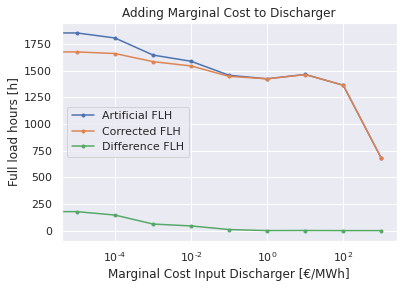

In [306]:
lines = FLH_b.iloc[20:30,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("Battery Full load hours [h]") #(full usage/year)

Text(0, 0.5, 'Full load hours [h]')

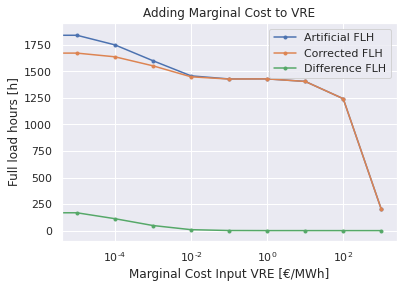

In [307]:
lines = FLH_b.iloc[0:10,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input VRE [€/MWh]")
plt.ylabel("Battery Full load hours [h]") #(full usage/year)

Text(0, 0.5, 'Full load hours [h]')

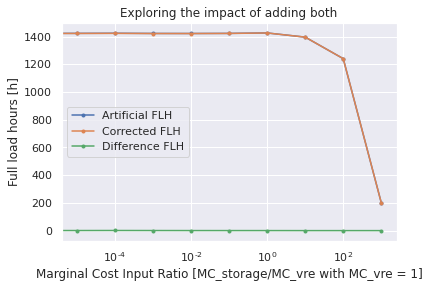

In [308]:
lines = FLH_b.iloc[10:20,:].plot(style='.-')
plt.xscale("log")
plt.title("Exploring the impact of adding both")
plt.xlabel("Marginal Cost Input Ratio [MC_storage/MC_vre with MC_vre = 1]")
plt.ylabel("Battery Full load hours [h]") #(full usage/year)

## Plot FLH _H2

In [298]:
##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

In [301]:
FLH_h2.iloc[0:10,:]

,Artificial FLH,Corrected FLH,Difference FLH
scenario,,,
0.00000,1862.594398,1676.251519,186.342879
0.00001,1840.710873,1672.635456,168.075417
0.00010,1750.016092,1637.727281,112.288811
0.00100,1600.520502,1552.643588,47.876914
0.01000,1458.181380,1449.240955,8.940424
0.10000,1429.113255,1428.146072,0.967182
1.00000,1429.870890,1429.769205,0.101685
10.00000,1405.801383,1405.727050,0.074334
100.00000,1242.945683,1242.941062,0.004621


Text(0, 0.5, 'Full load hours [h]')

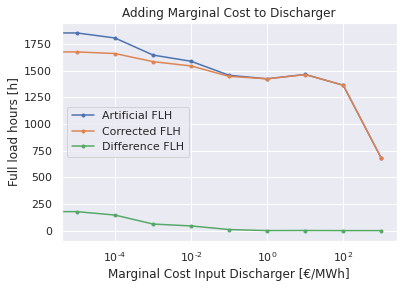

In [306]:
lines = FLH_h2.iloc[20:30,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("H2 Full load hours [h]") #(full usage/year)

Text(0, 0.5, 'Full load hours [h]')

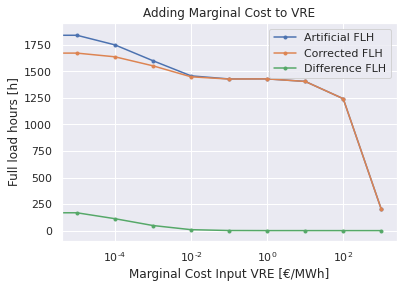

In [307]:
lines = FLH_h2.iloc[0:10,:].plot(style='.-')
plt.xscale("log")
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input VRE [€/MWh]")
plt.ylabel("H2 Full load hours [h]") #(full usage/year)

Text(0, 0.5, 'Full load hours [h]')

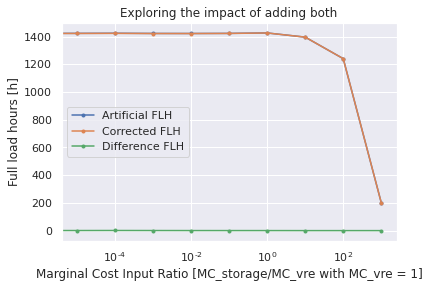

In [308]:
lines = FLH_h2.iloc[10:20,:].plot(style='.-')
plt.xscale("log")
plt.title("Exploring the impact of adding both")
plt.xlabel("Marginal Cost Input Ratio [MC_storage/MC_vre with MC_vre = 1]")
plt.ylabel("H2 Full load hours [h]") #(full usage/year)

## Plot Total System Cost 

In [257]:
##NOTES. 
#mc_discharger = n10-n19
#mc_ratio = n20-n29
#mc_vre = n30-n39

Text(0, 0.5, 'Total System Costs [B€ p.a.]')

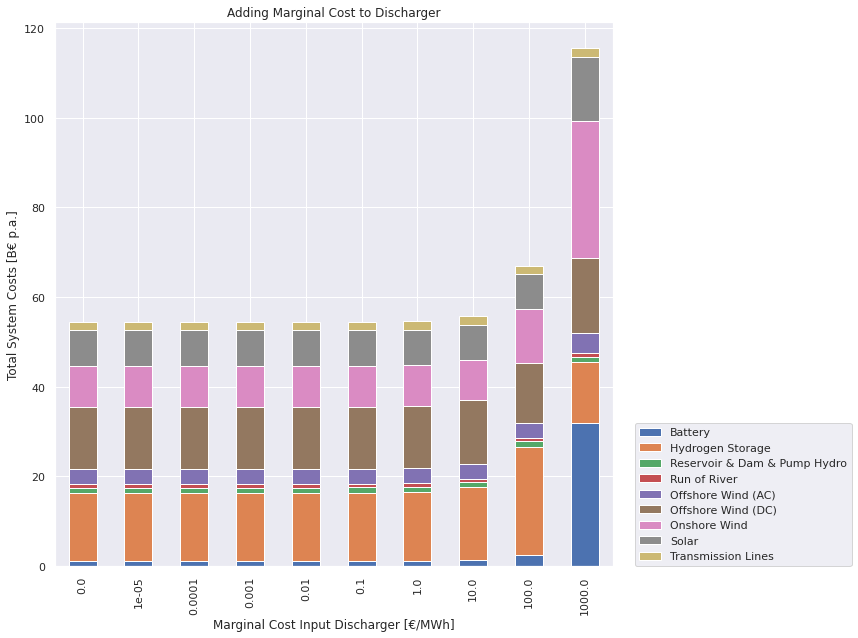

In [258]:

costs.iloc[:,0:10].T.plot.bar(stacked=True, figsize=(10,10))
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to Discharger")
plt.xlabel("Marginal Cost Input Discharger [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")


Text(0, 0.5, 'Total System Costs [B€ p.a.]')

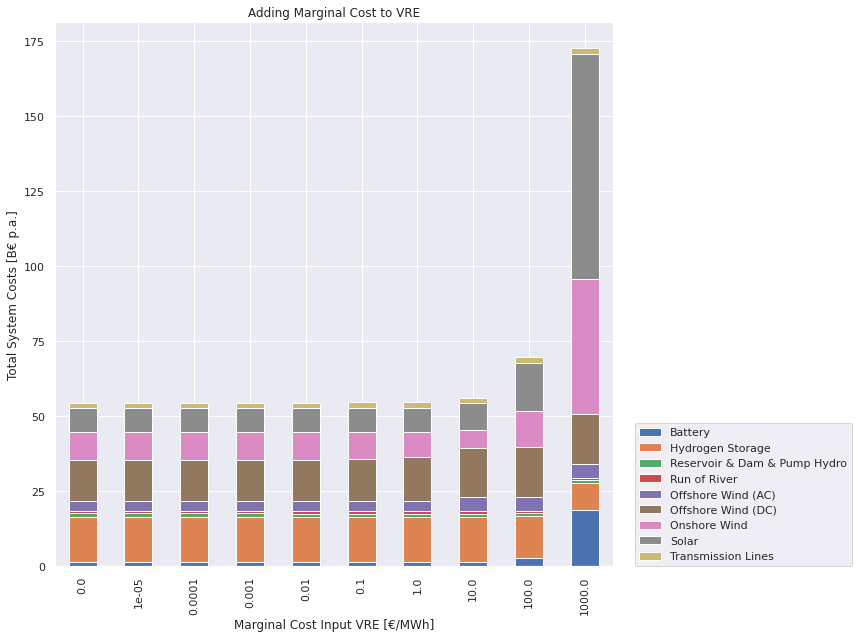

In [270]:
costs.iloc[:,20:30].T.plot.bar(stacked=True, figsize=(10,10))
plt.legend(loc=(1.04,0))
plt.title("Adding Marginal Cost to VRE")
plt.xlabel("Marginal Cost Input VRE [€/MWh]")
plt.ylabel("Total System Costs [B€ p.a.]")

Text(0, 0.5, 'Total System Costs [B€ p.a.]')

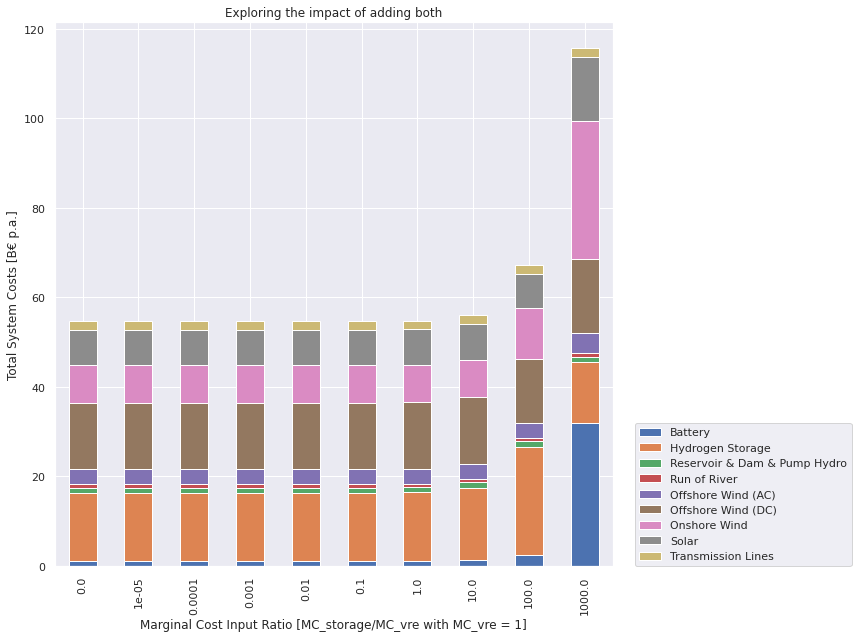

In [260]:
costs.iloc[:,10:20].T.plot.bar(stacked=True, figsize=(10,10))
plt.legend(loc=(1.04,0))
plt.title("Exploring the impact of adding both")
plt.xlabel("Marginal Cost Input Ratio [MC_storage/MC_vre with MC_vre = 1]")
plt.ylabel("Total System Costs [B€ p.a.]")

In [ ]:
###CHECK
values = list(ns.values())
keys = list(ns.keys())
objective =  []

for i in range(0, len(keys)):
    C = calculate_objective(values[i], keys[i])
    objective.append(C)

In [309]:
objective

[('n0', 45.04557951555089),
 ('n1', 45.04802809915171),
 ('n2', 45.05202027919484),
 ('n3', 45.04957191219101),
 ('n4', 45.05691070707301),
 ('n5', 45.046363981795835),
 ('n6', 45.141246790037094),
 ('n7', 46.34530177167958),
 ('n8', 58.22990706985783),
 ('n9', 108.24398712083652),
 ('n10', 45.28085802567906),
 ('n11', 45.27941290038056),
 ('n12', 45.28031490116619),
 ('n13', 45.279304112260995),
 ('n14', 45.27933370387451),
 ('n15', 45.28785788412464),
 ('n16', 45.391903761157),
 ('n17', 46.61262463188146),
 ('n18', 58.46204317124266),
 ('n19', 108.37555140794225),
 ('n20', 45.0476420465717),
 ('n21', 45.04902082598671),
 ('n22', 45.05018293466393),
 ('n23', 45.05231207351525),
 ('n24', 45.069530145722034),
 ('n25', 45.04910843959017),
 ('n26', 45.27884247358112),
 ('n27', 46.85658682545441),
 ('n28', 60.96823904478519),
 ('n29', 164.61649133315532)]